In [ ]:
pip install scipy

In [ ]:
pip install pymoo

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('leukemia.mat')
dataset_name = "leukemia,72"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('colon.mat')
dataset_name = "colon,62"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('Prostate.mat')
dataset_name = "Prostate,102"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('ALLAML.mat')
dataset_name = "ALLAML,72"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('lymphoma.mat')
dataset_name = "lymphoma,96"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('GLIOMA.mat')
dataset_name = "Glioma,50"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('lung.mat')
dataset_name = "Lung,203"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [1]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('GLI_85.mat')
dataset_name = "GLI,85"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

X = [[2.9844273e+04 1.0116590e+03 6.8939100e+02 ... 4.8630000e+00
  2.6816000e+01 2.2039000e+01]
 [1.7265617e+04 7.9323000e+02 5.8433800e+02 ... 1.9493000e+01
  9.1644000e+01 2.7866000e+01]
 [2.5947941e+04 8.8063700e+02 8.6230100e+02 ... 4.0740000e+00
  3.7106000e+01 9.8720000e+00]
 ...
 [2.7075715e+04 2.3778700e+02 4.1441800e+02 ... 1.7815100e+02
  2.5199000e+01 2.4611000e+01]
 [2.5782137e+04 8.5159000e+02 1.3458760e+03 ... 2.0294000e+01
  2.5502000e+01 2.1344000e+01]
 [2.3462324e+04 1.4078590e+03 2.5697960e+03 ... 8.1280000e+00
  2.5786000e+01 6.0070000e+01]]
Y = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
22283
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 17 16:19:02 2015', '__version__': '1.0', '__globals__': [], 'Y': array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]

In [ ]:
# import scipy.io

# # # Load the .mat file
# mat_contents = scipy.io.loadmat('leukemia.mat')

# # Display the contents
# #print(mat_contents)
# data = mat_contents
# X = data['X']
# Y=data['Y'].ravel()
# print("X =",X)
# print("Y =",Y)
# print(X.shape[1])
# print(data)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from pymoo.indicators.hv import HV
import pandas as pd
from pymoo.core.sampling import Sampling
import random
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import os
from sklearn.model_selection import KFold
import pickle

In [3]:
X.shape, Y.shape

((85, 22283), (85,))

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42,stratify=Y)

In [5]:
data_test_saved = {
    'X_test': X_test,
    'Y_test': Y_test
}
with open(f'data_test{dataset_name}.pkl', 'wb') as f:
    pickle.dump(data_test_saved, f)

In [6]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((59, 22283), (26, 22283), (59,), (26,))

In [7]:
# Check the distribution of classes
def class_distribution(X):
    unique, counts = np.unique(X, return_counts=True)
    return dict(zip(unique, counts))

# Original dataset distribution
original_dist = class_distribution(X)
print("Original dataset distribution:", original_dist)

# Training set distribution
train_dist = class_distribution(X_train)
print("Training set distribution:", train_dist)

# Test set distribution
test_dist = class_distribution(X_test)
print("Test set distribution:", test_dist)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
# Check the distribution of classes
def class_distribution(Y):
    unique, counts = np.unique(Y, return_counts=True)
    return dict(zip(unique, counts))

# Original dataset distribution
original_dist = class_distribution(Y)
print("Original dataset distribution:", original_dist)

# Training set distribution
train_dist = class_distribution(Y_train)
print("Training set distribution:", train_dist)

# Test set distribution
test_dist = class_distribution(Y_test)
print("Test set distribution:", test_dist)

Original dataset distribution: {1: 26, 2: 59}
Training set distribution: {1: 18, 2: 41}
Test set distribution: {1: 8, 2: 18}


In [9]:
print(X_train)
print(Y_train)

[[1.6782559e+04 1.3257180e+03 1.9289730e+03 ... 5.4310000e+01
  2.4895000e+01 3.4694000e+01]
 [1.4206392e+04 7.9524800e+02 4.9039300e+02 ... 1.3700000e+01
  2.5583000e+01 2.7229000e+01]
 [2.2302680e+04 1.1052940e+03 3.9948000e+02 ... 1.0447300e+02
  5.8145000e+01 3.0821000e+01]
 ...
 [2.5855035e+04 2.6298310e+03 1.2399360e+03 ... 1.7037000e+01
  1.2885000e+01 1.9279000e+01]
 [2.3500504e+04 7.3581800e+02 5.7580200e+02 ... 3.2588000e+01
  6.2135000e+01 4.0287000e+01]
 [2.0970387e+04 8.8429900e+02 1.0463150e+03 ... 3.0663000e+01
  4.6270000e+01 3.8536000e+01]]
[2 1 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 2 2 1 1 2 2 2 2 2 2 2 1 1 2 2 1 1
 2 1 2 2 1 1 2 1 2 1 2 2 2 2 2 2 2 2 1 2 1 2]


In [ ]:
class MyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=2000, # decision variables
                         n_obj=2,  # two objective functions
                        n_ieq_constr=1 
                        )

    def _classification_error(self, bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(i)
  
        if len(featureNames) == 0:
            return 1
        else:
            trainx = X_train[:,featureNames]
            trainy = Y_train
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(trainx, trainy)
            Y_pred = knn.predict(trainx)
            ac = accuracy_score(trainy, Y_pred)
            return 1 - ac

    def _features_number(self, bitstring):
        return sum(bitstring)

    def _constrain(self,bitstring):
        return 1 - sum(bitstring)
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self._features_number(x[i]) for i in range(len(x))]
        f2 = [self._classification_error(x[i]) for i in range(len(x))]
        g1 = [self._constrain(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

In [10]:
class generate_population(Sampling):
        def __init__(self):
            super().__init__()
            
        def _do(self, problem, n_samples, **kwargs):
            total_features = 22283
            population_size = 100
            population = []
            for _ in range(population_size):
                n = random.randint(1, total_features) 
                individual = [0] * total_features
                selected_indices = random.sample(range(total_features), n)
                for idx in selected_indices :
                    individual[idx] = 1
                population.append(individual)
            return population

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain, ytrain)
ypred = knn.predict(xtrain)
ac = accuracy_score(ytrain, ypred)
print(ac)
print("Classification error on training sets using all features: " + str(1 - ac))
ypred = knn.predict(xtest)
ac = accuracy_score(ytest, ypred)
print(ac)
print("Classification error on testing sets using all features: " + str(1 - ac))

print("###################################################################################")

0.8813559322033898
Classification error on training sets using all features: 0.11864406779661019
0.7307692307692307
Classification error on testing sets using all features: 0.2692307692307693
###################################################################################


In [ ]:
#problem = FeatureSelectionProblem(X,Y)


In [ ]:
problem = MyProblem()

In [ ]:
algorithm = NSGA2(pop_size=100,
                  sampling=generate_population(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

In [ ]:
termination = get_termination("n_gen", 40)

In [ ]:
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
pop_test = res.pop
solutions = res.X

In [ ]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

In [ ]:
# Get the minimum error from the optimization result
min_error_train = np.min(f[:, 1])

# Print the minimum error with increased decimals
print("Minimum error on training dataset: {:.10f}".format(min_error_train))

In [ ]:
# print(res.F[:,1])
# print(res.F[:,0])
# print(pop.get("F")[:,0])
# print(pop.get("F")[:,1])

In [ ]:
def evaluate_on_test(X_test, Y_test, solution):
    feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
    if len(feature_indices) == 0:
        return [X.shape[1], 1.0]
    else:
        X_test_selected = X_test[:, feature_indices]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train[:, feature_indices], Y_train)
        Y_pred = knn.predict(X_test_selected)
        error_rate = 1 - accuracy_score(Y_test, Y_pred)
        return [len(feature_indices), error_rate]

In [ ]:
# Evaluate each solution on the test data
print(len(pop_test.get("X")))
print(len(res.X))
print(pop_test.get("X"))
Solutions_test = np.array([evaluate_on_test(X_test, Y_test, solution) for solution in res.X])

# Perform non-dominated sorting
nds = NonDominatedSorting().do(Solutions_test)

# Extract the Pareto front solutions
pareto_front_indices = nds[0]
pareto_front_objectives_test = Solutions_test[pareto_front_indices]


# print(f"Total number of solutions: {len(Solutions_test)}")
# print(f"Number of Pareto front solutions: {len(pareto_front_indices)}")
# print("Some solutions from the last generation:", Solutions_test[:5])
# print("Pareto front solutions:", pareto_front_objectives)


# Plot the Pareto front graph
print("The final Pareto front is plotted as:")
plt.scatter(Solutions_test[:, 0], Solutions_test[:, 1], edgecolor="blue", facecolor="none", label="Solutions")
plt.scatter(pareto_front_objectives_test[:, 0], pareto_front_objectives_test[:, 1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto front")
plt.xlabel('Number of Features')
plt.ylabel('Test Error')
plt.legend()
plt.title("Visualization of the Final Pareto Front after NDS")
plt.show()

In [ ]:
# Plot the Pareto front for test data
import matplotlib.pyplot as plt

plt.scatter(f_test[:, 0], f_test[:, 1], edgecolor="blue", facecolor="none", label="Test Data Pareto Front")
plt.scatter(optimal_solution[0], optimal_solution[1], marker='*', color='red', s=100, label="Optimal Solution")
plt.xlabel('Number of Features')
plt.ylabel('Error Rate')
plt.legend()
plt.title("Pareto Front on Test Data")
plt.show()

In [ ]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f_train = scaler.fit_transform(f)
hv_train = ind(f_train)
print("HV of the best pareto front train:" + str(round(hv_train, 2)))

In [ ]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f_t = scaler.fit_transform(Solutions_test)
hv_test = ind(f_t)
print("HV of the best pareto front test:" + str(round(hv_test, 2)))

In [ ]:
# Extracting and plotting the Pareto Front from all generations
pareto_fronts = [gen.opt.get("F") for gen in res.history]

for i, pareto in enumerate(pareto_fronts):
    plt.scatter(pareto[:, 0], pareto[:, 1])

plt.xlabel('Number of Features')
plt.ylabel('Training Error Rate')
plt.title('Pareto Front Evolution')
plt.legend()
plt.show()



In [ ]:
# Get the minimum error from the optimization result
min_error_test = np.min(Solutions_test[:,1])

# Print the minimum error
print("Minimum error on testing dataset:", min_error_test)

In [ ]:
# Get the minimum error from the optimization result
min_error_train = np.min(res.F[:, 1])

# Find the row(s) where the error is minimized
min_error_indices = np.where(res.F[:, 1] == min_error_train)[0]

# Get the corresponding solutions with minimum error
solutions_with_min_error = res.X[min_error_indices]

# Get the number of features for the solutions with minimum error
num_features_with_min_error_train = [np.count_nonzero(solution) for solution in solutions_with_min_error]

# Print the number of features with minimum error
print("Number of features with minimum error on train:", num_features_with_min_error_train)

In [ ]:
num_features_with_min_error_test = np.min(Solutions_test[:,0])
print("Number of features with minimum error on test data:",num_features_with_min_error_test)

In [ ]:
from prettytable import PrettyTable

# Create a PrettyTable instance
table = PrettyTable()

# Set the column alignment
table.align = "l"

# Define the column names
table.field_names = ["Info abt. Db", "H.V.(Train)", "H.V.(Test)", 
                     "Min. Error(Train)", "Min. Err(Test)", "Feat.w Min.Err(Trn.)", 
                     "Feat.w Min.Err(Tst)"]

# Populate the table with data
dataset_info = "Lukemia,72,7070"
dataset_name = "Lukemia"
hv_training = "{:.2f}".format(hv_train)
hv_testing = "{:.2f}".format(hv_test)
min_error_training = "{:.5f}".format(min_error_train)
min_error_testing = "{:.5f}".format(min_error_test)
min_error_features_training = num_features_with_min_error_train[0]
min_error_features_testing = num_features_with_min_error_test


# Add data to the table row
table.add_row([dataset_info, hv_training, hv_testing, min_error_training, min_error_testing,
               min_error_features_training, min_error_features_testing])


# Print the table
print(table)


# (TRAIN + Validation ) For Voting




In [12]:
class MyProblem_Split(Problem):
    def __init__(self, X_train1,Y_train1):
        super().__init__(n_var=22283,  # decision variables
                         n_obj=2,    # two objective functions
                         n_ieq_constr=1  # one inequality constraint
                        )
        self.X_train1 = X_train1
        self.Y_train1 = Y_train1

    def _classification_error(self, bitstring):
        featureNames = [i for i in range(len(bitstring)) if bitstring[i] == 1]
        
        if len(featureNames) == 0:
            return 1
        else:
            trainx = self.X_train1[:, featureNames]
            trainy = self.Y_train1
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(trainx, trainy)
            Y_pred = knn.predict(trainx)
            ac = accuracy_score(trainy, Y_pred)
            return 1 - ac

    def _features_number(self, bitstring):
        return sum(bitstring)

    def _constrain(self, bitstring):
        return 1 - sum(bitstring)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self._features_number(x[i]) for i in range(len(x))]
        f2 = [self._classification_error(x[i]) for i in range(len(x))]
        g1 = [self._constrain(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])
        
# def evaluate_on_valid_data(X, Y, solution):
#     feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
#     if len(feature_indices) == 0:
#         return [X_test.shape[1], 1.0]
#     else:
#         X_selected = X_train[:, feature_indices]
#         testx = X[:,feature_indices]
#         knn = KNeighborsClassifier(n_neighbors=5)
#         knn.fit(X_selected, Y_train)
#         ypred = knn.predict(testx)
#         ac = accuracy_score(ytest, ypred)
#         error_rate = 1 - ac
#         return [len(feature_indices), error_rate]
def evaluate_on_valid_data(X_train, Y_train, X_valid, Y_valid, solution):
    feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
    if len(feature_indices) == 0:
        return [X_valid.shape[1], 1.0,np.zeros_like(solution)]
    else:
        X_selected = X_train[:, feature_indices]
        X_valid_selected = X_valid[:, feature_indices]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_selected, Y_train)
        y_pred = knn.predict(X_valid_selected)
        ac = accuracy_score(Y_valid, y_pred)
        error_rate = 1 - ac
        return [len(feature_indices), error_rate,solution]

Run 1:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


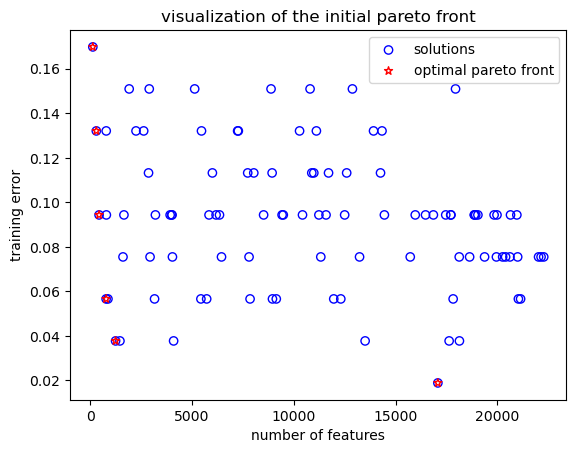

the final pareto front is plotted as: 


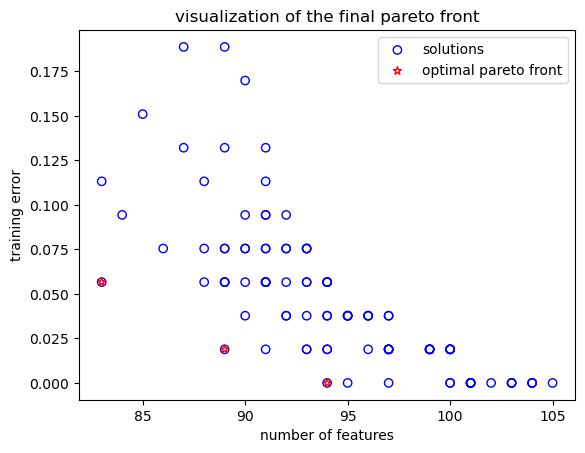

0.0
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


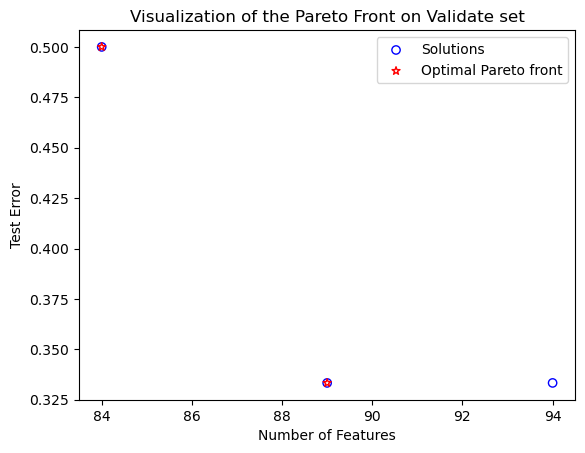

Non-dominated binary vector with 89 features:
89.0
[121, 424, 548, 629, 982, 1033, 1201, 1281, 1362, 1383, 1786, 2116, 2133, 2268, 2393, 2523, 2634, 2638, 2660, 3070, 3133, 3377, 3472, 3942, 4203, 4372, 4427, 4708, 4963, 5058, 5288, 5389, 5532, 6217, 6276, 6664, 6911, 7121, 7432, 7710, 7978, 8336, 8627, 9077, 9195, 9477, 9651, 9930, 10656, 11195, 11271, 11855, 11940, 11956, 12275, 12519, 12572, 12819, 13034, 13086, 14447, 14918, 15622, 15889, 17253, 17357, 17674, 17697, 18026, 18282, 18381, 18855, 19251, 19366, 19559, 19611, 20123, 20335, 20345, 20685, 20737, 20739, 20909, 21185, 21320, 21754, 21877, 21941, 22000]
0.7692307692307693
0.23076923076923073
Run 2:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


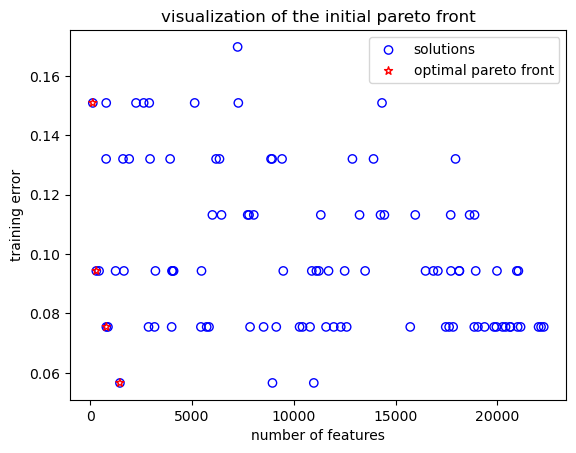

the final pareto front is plotted as: 


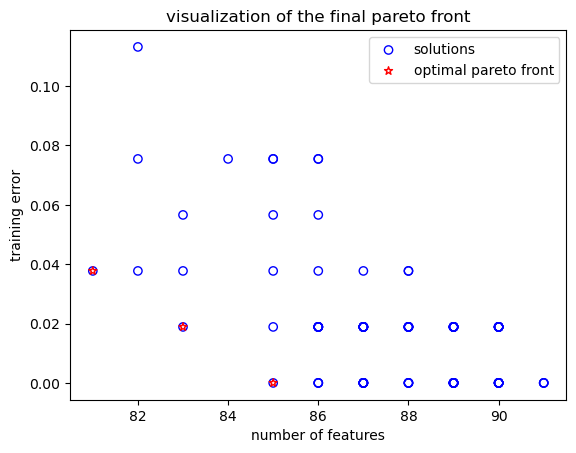

0.0
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


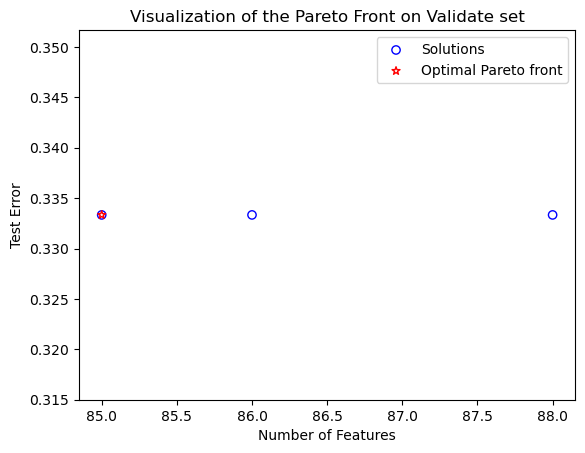

Non-dominated binary vector with 85 features:
87.0
[173, 349, 424, 979, 1281, 1602, 1786, 2133, 2638, 2660, 2972, 3119, 4427, 4708, 4929, 5052, 5067, 6217, 6276, 6679, 6734, 6862, 6886, 6911, 6931, 7145, 7645, 7710, 7881, 8152, 8336, 8627, 8830, 9026, 9077, 9204, 9513, 9651, 9930, 10014, 10383, 10647, 11530, 11855, 11871, 11956, 12275, 12285, 12519, 12817, 12819, 13086, 13600, 13862, 14296, 14359, 15256, 15889, 16148, 16312, 16503, 16546, 17253, 17357, 17405, 17674, 17697, 18026, 18282, 18381, 18565, 19251, 19366, 20042, 20123, 20335, 20345, 20455, 20739, 20791, 20924, 21530, 21754, 21877, 21941]
0.7307692307692307
0.25
Run 3:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


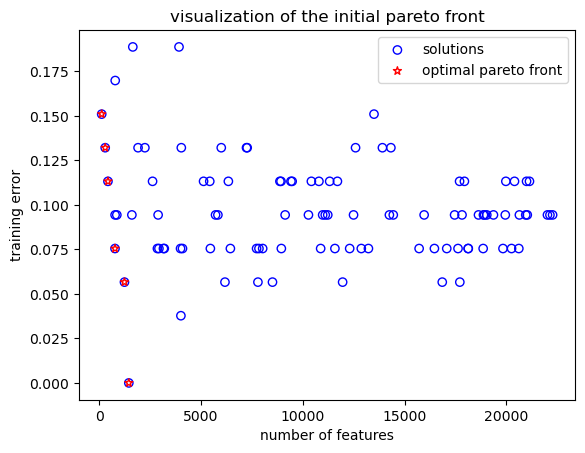

the final pareto front is plotted as: 


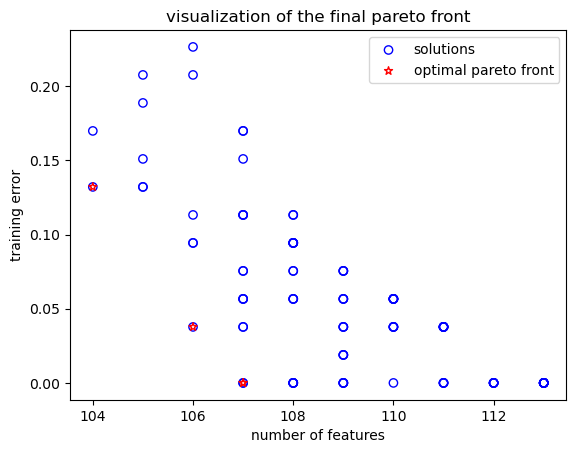

0.0
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


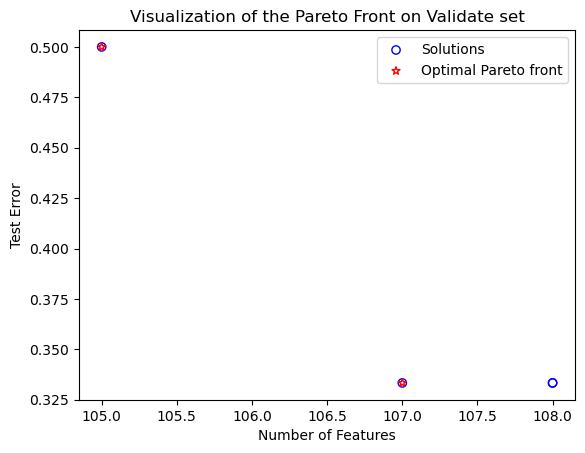

Non-dominated binary vector with 107 features:
93.66666666666667
[173, 424, 548, 1281, 1786, 2116, 2133, 2210, 2268, 2393, 2523, 2634, 2638, 2660, 2760, 2972, 3070, 3119, 3609, 4056, 4228, 4372, 4427, 5058, 5067, 5288, 5532, 6187, 6217, 6276, 6664, 6679, 6691, 6734, 6862, 6886, 6931, 7121, 7280, 7710, 7881, 7978, 8336, 8388, 8744, 8830, 9026, 9077, 9204, 9477, 9651, 9930, 10014, 10383, 10647, 11096, 11195, 11530, 11855, 11940, 12040, 12275, 12285, 12519, 12568, 12819, 13086, 13457, 13600, 13862, 14295, 14359, 15256, 15622, 15817, 15889, 16148, 16503, 16526, 16546, 17239, 17253, 17357, 17697, 18026, 18157, 18282, 18381, 18565, 19251, 19366, 19554, 19559, 19611, 20042, 20123, 20335, 20455, 20516, 20685, 20739, 20791, 21009, 21530, 21754, 21877, 21941]
0.6923076923076923
0.2692307692307692
Run 4:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


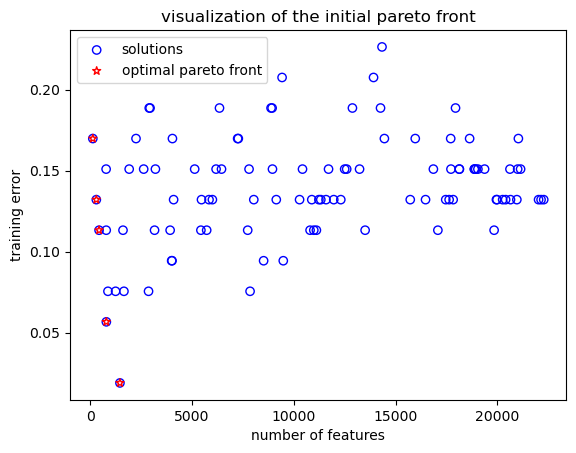

the final pareto front is plotted as: 


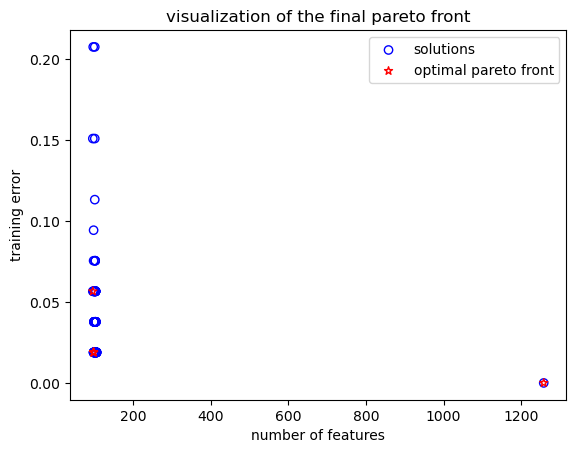

0.0
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


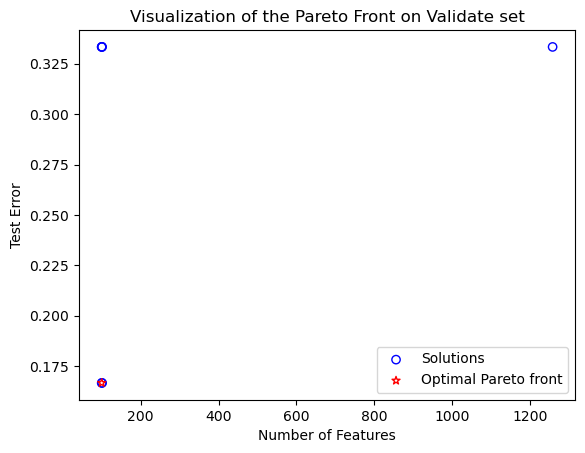

Non-dominated binary vector with 100 features:
95.25
[173, 979, 1281, 1786, 2116, 2133, 2210, 2268, 2393, 2523, 2634, 2638, 2660, 2760, 2972, 3070, 3472, 3609, 3982, 4056, 4203, 4228, 4372, 4427, 4708, 4929, 5052, 5058, 5067, 5243, 5532, 6187, 6276, 6664, 6734, 6862, 6886, 6911, 7145, 7280, 7881, 7978, 8627, 9026, 9077, 9477, 9513, 9651, 9930, 10014, 10383, 10647, 11195, 11271, 11855, 11871, 11940, 11956, 12040, 12275, 12285, 12819, 13086, 13600, 13862, 13909, 14296, 14359, 15256, 15622, 15817, 15889, 16148, 16312, 17239, 17357, 17674, 17697, 17828, 18026, 18157, 18282, 18381, 18565, 19251, 19366, 19554, 19559, 20042, 20335, 20455, 20516, 20685, 20791, 20924, 21530, 21754, 21877, 21941, 22000]
0.7307692307692307
0.2692307692307693
Run 5:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


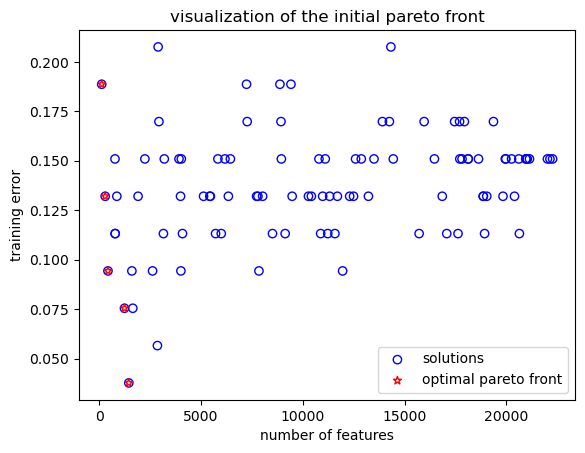

the final pareto front is plotted as: 


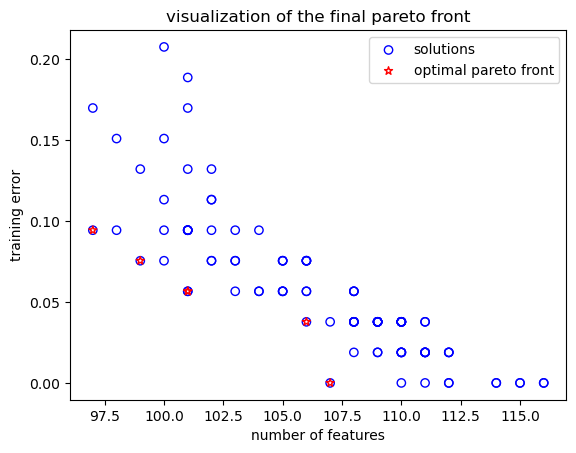

0.0
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


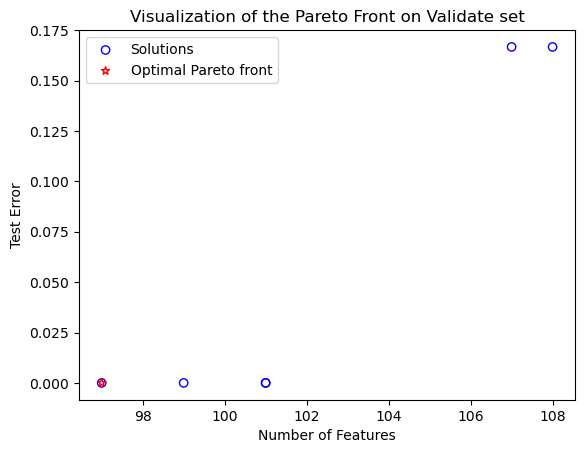

Non-dominated binary vector with 97 features:
95.6
[548, 1281, 1786, 2133, 2210, 2268, 2393, 2523, 2634, 2638, 2760, 2972, 3070, 3119, 3472, 3982, 4056, 4203, 4228, 4372, 4427, 4708, 4929, 5058, 5067, 5288, 5532, 6187, 6217, 6276, 6664, 6691, 6734, 6886, 6911, 6931, 7121, 7145, 7280, 7710, 7809, 7881, 7978, 8336, 8627, 9026, 9077, 9204, 9513, 9651, 10014, 10647, 11195, 11271, 11530, 11855, 11871, 11940, 11956, 12285, 12519, 13086, 13600, 13862, 13909, 14295, 14296, 15041, 15256, 15889, 16312, 17113, 17253, 17357, 17405, 17674, 17697, 17828, 18026, 18282, 18381, 18565, 19251, 19366, 19554, 19559, 19611, 20042, 20335, 20455, 20516, 20685, 20739, 20791, 21754, 21877, 22075]
0.8076923076923077
0.2538461538461539
Run 6:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


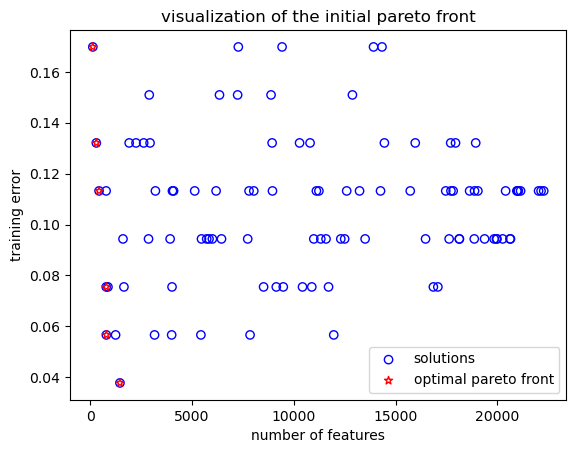

the final pareto front is plotted as: 


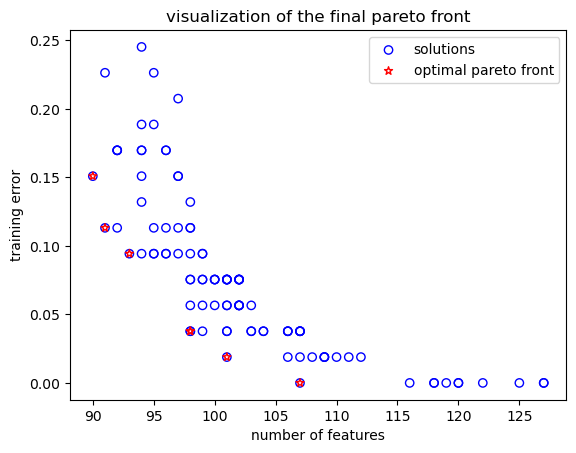

0.0
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


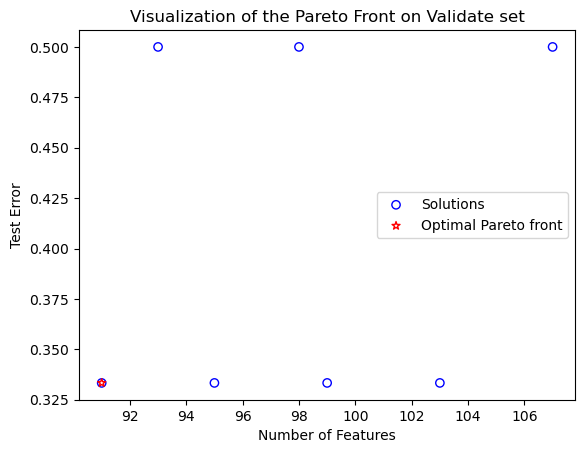

Non-dominated binary vector with 91 features:
94.83333333333333
[80, 173, 548, 1281, 1786, 2116, 2268, 2523, 2638, 2660, 3119, 3472, 3986, 4056, 4228, 4372, 4427, 4708, 4929, 5058, 5067, 5288, 6187, 6217, 6276, 6664, 6691, 6862, 6886, 6911, 6931, 7121, 7145, 7280, 7881, 7978, 8336, 8627, 8830, 9015, 9026, 9077, 9204, 9477, 9513, 9651, 9930, 9946, 10383, 10647, 11195, 11271, 11530, 11871, 11940, 11956, 12040, 12275, 12285, 12817, 13086, 13413, 13457, 13600, 13909, 14296, 14359, 14422, 15622, 15817, 15889, 16148, 16312, 17239, 17253, 17674, 17697, 18157, 19251, 19366, 19554, 19559, 20042, 20455, 20516, 20685, 20791, 20924, 21530, 21754, 21941]
0.7307692307692307
0.25641025641025644
Run 7:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


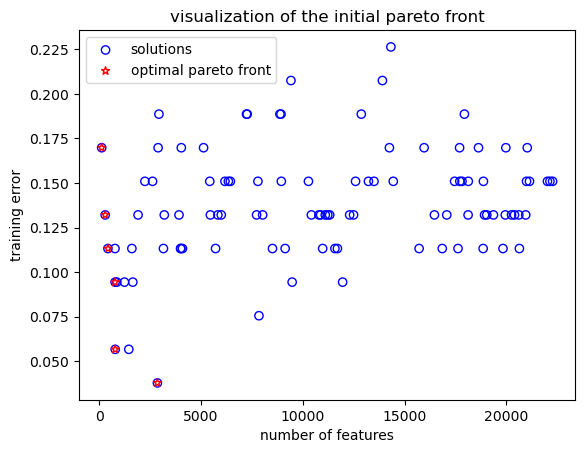

the final pareto front is plotted as: 


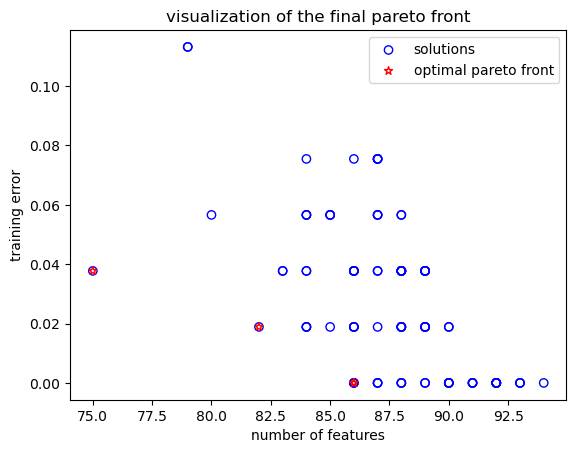

0.0
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


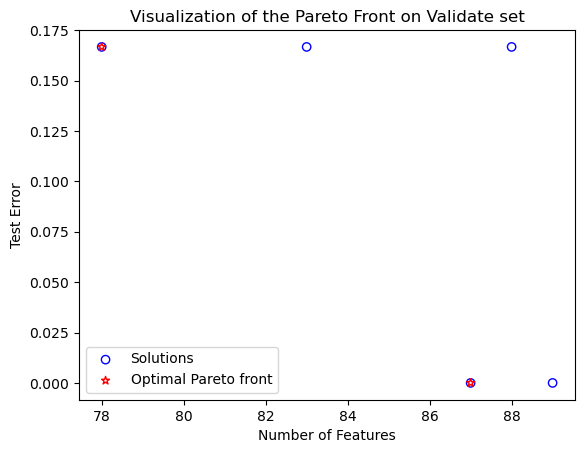

Non-dominated binary vector with 87 features:
93.71428571428571
[375, 548, 555, 2116, 2393, 2523, 2634, 2660, 2760, 2972, 3070, 3472, 4056, 4372, 4929, 5052, 5067, 5288, 5532, 6187, 6217, 6664, 6679, 6784, 6911, 6931, 7710, 7978, 8336, 8365, 8388, 8627, 8830, 9352, 9477, 9513, 9651, 9946, 10014, 10643, 10647, 11195, 11271, 11530, 11855, 11871, 11940, 11977, 11997, 12040, 12285, 12472, 12817, 12819, 13086, 13567, 13589, 13862, 13909, 14295, 14296, 15622, 16148, 16503, 17105, 17233, 17253, 17405, 17697, 17828, 18381, 18565, 19251, 19366, 19554, 19559, 20042, 20123, 20345, 20455, 20516, 20739, 20791, 21530, 21754, 21877, 21941]
0.7692307692307693
0.2527472527472528
Run 8:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


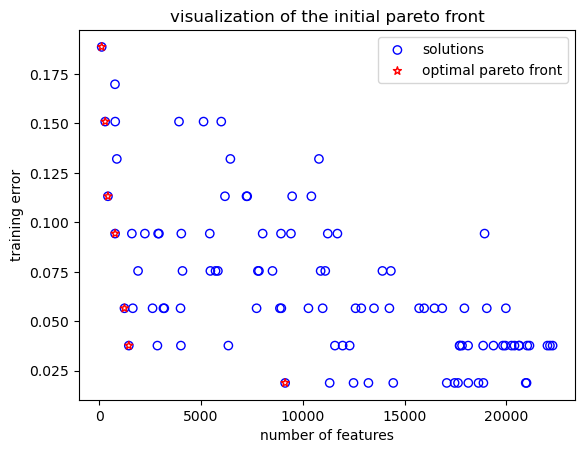

the final pareto front is plotted as: 


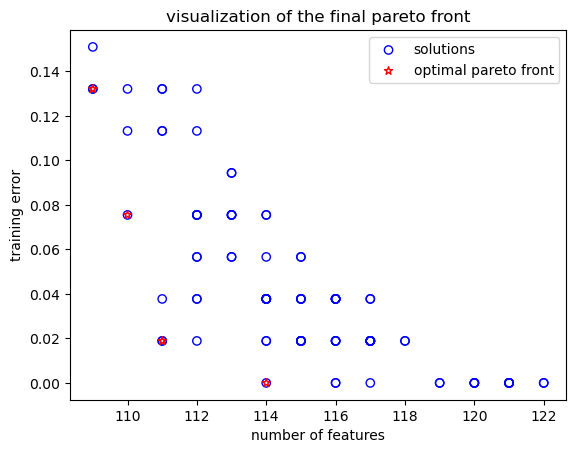

0.0
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


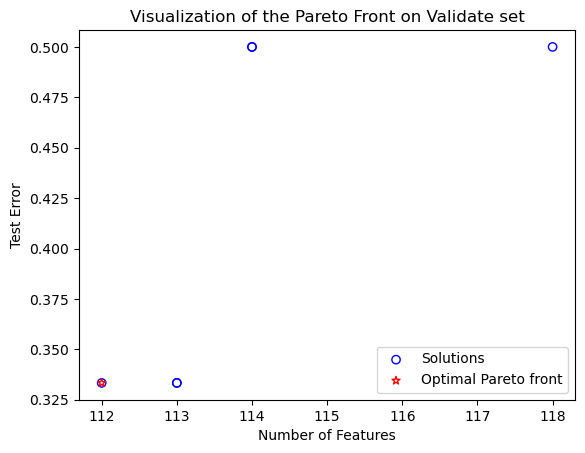

Non-dominated binary vector with 112 features:
96.0
[424, 548, 1281, 1786, 2116, 2133, 2210, 2268, 2393, 2523, 2634, 2638, 2660, 2760, 2972, 3070, 3119, 3472, 3609, 3982, 4056, 4203, 4228, 4372, 4708, 4929, 5052, 5058, 5067, 5288, 5532, 6187, 6217, 6276, 6664, 6679, 6691, 6734, 6862, 6886, 6911, 6931, 7121, 7145, 7280, 7710, 7881, 8627, 8830, 9026, 9204, 9477, 9513, 9651, 9946, 10014, 10383, 10647, 11096, 11195, 11271, 11530, 11855, 11871, 11940, 11956, 12040, 12285, 12519, 12817, 12819, 13086, 13457, 13600, 13862, 14295, 14296, 15256, 15622, 15817, 15889, 16312, 16503, 16546, 16934, 17253, 17357, 17405, 17674, 17697, 17828, 18026, 18157, 18282, 18381, 18565, 19366, 19554, 19559, 19611, 20123, 20335, 20345, 20455, 20516, 20791, 20924, 21009, 21754, 21877, 21941, 22000]
0.7307692307692307
0.25480769230769235
Run 9:
(53, 22283) (6, 22283) (53,) (6,)
the intial pareto front is plotted as: 


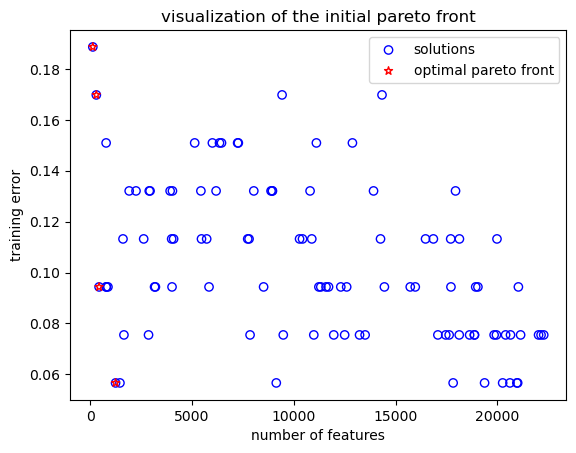

the final pareto front is plotted as: 


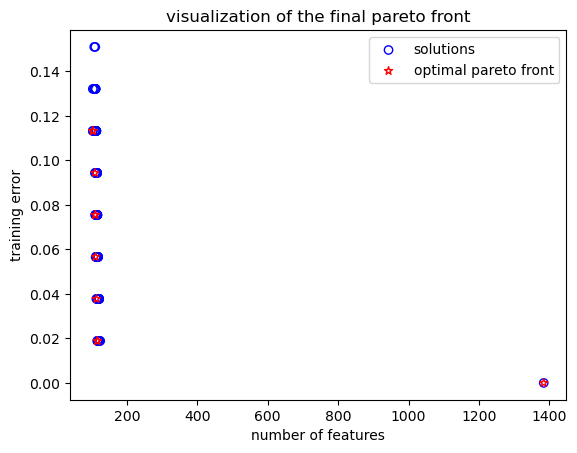

0.0
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


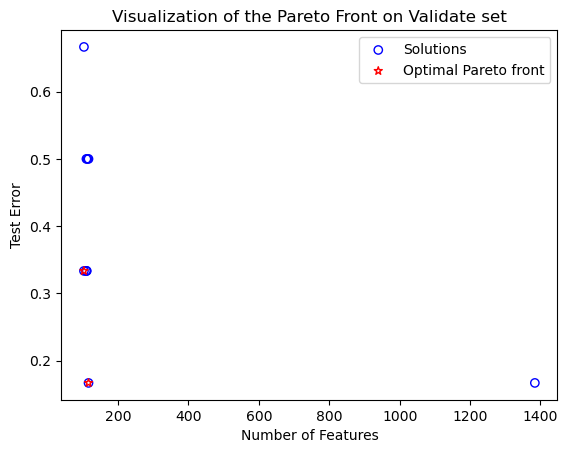

Non-dominated binary vector with 116 features:
98.22222222222223
[80, 173, 424, 548, 648, 1281, 1786, 2116, 2133, 2210, 2268, 2393, 2523, 2638, 2660, 3070, 3119, 3472, 3567, 3755, 3942, 4056, 4372, 4427, 4636, 4708, 4929, 5052, 5067, 5288, 5532, 6187, 6276, 6691, 6862, 6911, 7092, 7121, 7145, 7710, 7881, 7978, 8627, 9026, 9077, 9195, 9204, 9477, 9513, 9651, 9930, 9946, 10014, 10383, 10647, 11195, 11271, 11530, 11833, 11855, 11871, 11940, 11956, 12040, 12275, 12285, 12519, 12572, 12817, 12819, 13086, 13447, 13457, 13600, 13862, 13909, 14295, 14296, 14359, 15256, 15523, 15622, 15782, 15889, 16148, 16312, 16503, 17056, 17239, 17357, 17405, 17674, 17697, 17828, 18026, 18157, 18381, 18565, 19366, 19554, 19559, 19611, 20123, 20335, 20455, 20516, 20685, 20739, 20791, 20924, 21009, 21530, 21754, 21877, 21941, 22000]
0.7692307692307693
0.2521367521367522
Run 10:
(54, 22283) (5, 22283) (54,) (5,)
the intial pareto front is plotted as: 


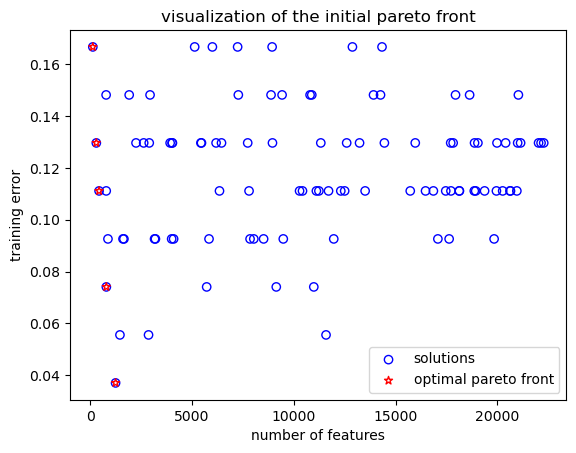

the final pareto front is plotted as: 


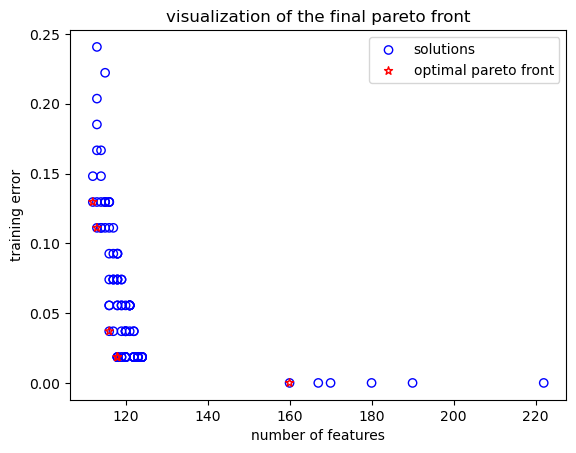

0.0
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


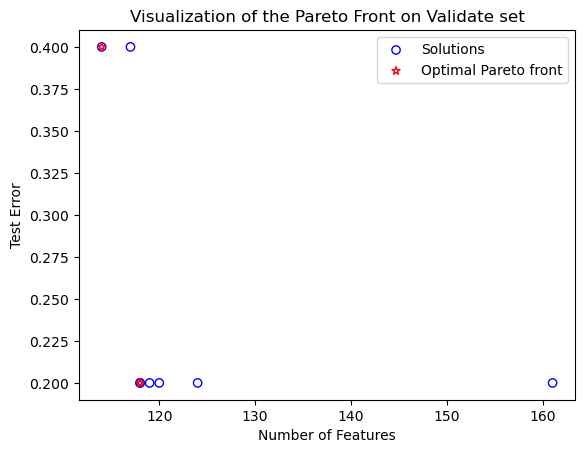

Non-dominated binary vector with 118 features:
100.2
[173, 424, 548, 979, 1281, 1786, 2116, 2133, 2210, 2268, 2393, 2523, 2634, 2638, 2660, 2760, 2972, 3070, 3472, 3609, 3982, 4056, 4203, 4228, 4372, 4427, 4708, 4929, 5052, 5058, 5067, 5288, 5320, 5532, 6187, 6217, 6276, 6664, 6679, 6691, 6734, 6862, 6886, 6931, 7121, 7710, 7978, 8443, 8572, 8627, 8830, 9026, 9077, 9204, 9477, 9513, 9651, 9946, 10014, 10383, 10428, 10647, 11195, 11271, 11855, 11871, 11940, 11956, 12040, 12275, 12285, 12817, 12819, 13086, 13457, 13600, 13862, 13909, 14295, 14296, 14359, 14731, 15256, 15622, 15817, 15889, 16148, 16503, 16546, 16615, 17239, 17253, 17357, 17674, 17697, 17828, 18026, 18157, 18282, 18381, 18565, 19251, 19554, 19559, 20042, 20123, 20335, 20345, 20455, 20516, 20685, 20739, 21009, 21530, 21667, 21754, 21877, 21941]
0.7307692307692307
0.2538461538461539
Non-dominated binary vector with 118 features:
101.81818181818181
[173, 424, 548, 979, 1281, 1786, 2116, 2133, 2210, 2268, 2393, 2523, 2634, 263

In [13]:
# Directory to save the solutions
save_dir = 'pareto_solutions'
os.makedirs(save_dir, exist_ok=True)

kfold = KFold(n_splits=10, shuffle=True, random_state=None)
fold_iterator = kfold.split(X_train, Y_train)
err_avg=[]
avg_min_train_error= []
min_err_validation=[]
k=[]
# Loop for 10 runs
for run in range(1, 10+1):
#for run in range(0, 1):
    print(f"Run {run}:")
    train_indices, test_indices = next(fold_iterator)
    X_train1, X_valid1 = X_train[train_indices], X_train[test_indices]
    Y_train1, Y_valid1 = Y_train[train_indices], Y_train[test_indices]
    print(X_train1.shape,X_valid1.shape,Y_train1.shape, Y_valid1.shape)
    #print(X_train.shape, Y_train.shape)
    #X_train1, X_valid1, Y_train1, Y_valid1 = train_test_split(X_train, Y_train, test_size=0.3, random_state=None)
    problem_split = MyProblem_Split(X_train1,Y_train1)
    algorithm = NSGA2(pop_size=100,
                  sampling=generate_population(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)
    termination = get_termination("n_gen", 50)
    res = minimize(problem_split,
                   algorithm,
                   termination,
                   seed=42,
                   save_history=True,
                   verbose=False)

    i_f = res.history[0].opt.get("F")
    i_pop = res.history[0].pop
    f = res.F
    pop = res.pop
    pop_valid = res.pop
    solutions = res.X
    print("the intial pareto front is plotted as: ")
    plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
    plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
    plt.xlabel('number of features')
    plt.ylabel('training error')
    plt.legend()
    plt.title("visualization of the initial pareto front")
    plt.show()
    print("the final pareto front is plotted as: ")
    plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
    plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
    plt.xlabel('number of features')
    plt.ylabel('training error')
    plt.legend()
    plt.title("visualization of the final pareto front")
    plt.show()

    avg_min_train_error.append(np.min(f[:,1]))
    avg_err_train=np.mean(avg_min_train_error)
    print(avg_err_train)
    # Evaluate each solution on the validation data 
    results = [evaluate_on_valid_data(X_train1, Y_train1, X_valid1, Y_valid1, solution) for solution in res.X]    
    
    
    # Separate the main results and binary vectors
    Solutions_valid = np.array([result[:2] for result in results])
    binary_vectors = [result[2] for result in results]
    
    
    # Perform non-dominated sorting
    nds = NonDominatedSorting().do(Solutions_valid)
    
    
    # Extract the Pareto front solutions
    pareto_front_indices = nds[0]
    pareto_front_objectives = Solutions_valid[pareto_front_indices]
    
    
    non_dominated_binary_vectors = [binary_vectors[i] for i in pareto_front_indices]
    
    print(non_dominated_binary_vectors)
    
    
    
    # Save the Pareto front binary vectors to a file
    file_path = os.path.join(save_dir, f'pareto_front_solutions_run_{run}_{dataset_name}.npy')
    np.save(file_path, non_dominated_binary_vectors)



    # Plot the Pareto front graph
    print("The final Pareto front is plotted as:")
    plt.scatter(Solutions_valid[:, 0], Solutions_valid[:, 1], edgecolor="blue", facecolor="none", label="Solutions")
    plt.scatter(pareto_front_objectives[:, 0], pareto_front_objectives[:, 1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto front")
    plt.xlabel('Number of Features')
    plt.ylabel('Test Error')
    plt.legend()
    plt.title("Visualization of the Pareto Front on Validate set")
    plt.show()
    
    
    min_err_validation.append(np.min(pareto_front_objectives[:, 1]))
    avg_min_error_valid=np.mean(min_err_validation)
    
    with open(f'data_test{dataset_name}.pkl', 'rb') as f:
        data_test_open = pickle.load(f)
    X_test_open = data_test_open['X_test']
    Y_test_open = data_test_open['Y_test']
    
    
    for idx, vector in enumerate(non_dominated_binary_vectors):
        low_error=np.min(Solutions_valid[:,1])
        feature_no=np.where(low_error==Solutions_valid[:,1])[0]
        feature_index = [i for i in range(len(vector)) if vector[i] == 1]
        for i,f in Solutions_valid[feature_no]:
            if(i==len(feature_index)):
                print(f"Non-dominated binary vector with {len(feature_index)} features:")
                k.append(len(feature_index))
                avg_feat_evry_run = np.mean(k)
                print(np.mean(k))
                print(feature_index)
                selected_features = feature_index
                X_selected = X_train[:, selected_features]
                testx = X_test_open[:,selected_features]
                knn = KNeighborsClassifier(n_neighbors=5)
                knn.fit(X_selected, Y_train)
                ypred = knn.predict(testx)
                ac = accuracy_score(Y_test_open, ypred)
                err_test = 1-ac
                err_avg.append(err_test)
                print(ac)
                #print(acc_avg)
                test_err = np.mean(err_avg)
                print(np.mean(err_avg))
    

    
   
    

In [ ]:
#     free=np.min(pareto_front_objectives[:,1])
#     # Find the row(s) where the error is minimized
#     min_error_indices = np.where(free==pareto_front_objectives[:,1])[0]
#     print(pareto_front_objectives[min_error_indices])
#     #print(pareto_front_solutions[min_error_indices].flatten())
    
    
#     l=0;
#     for i in pareto_front_solutions[min_error_indices]:
#         for j in i:
#             if(j==1):
#                 l+=j;     
#     print(l)
        #print(i)
    #print(pareto_front_solutions[min_error_indices])
    #print(min_error_indices)

In [ ]:
# acc_avg=[]
# for i in range(0,10):
#     selected_features = pareto_front_solutions[min_error_indices].flatten()
#     X_selected = X_train[:, selected_features]
#     testx = X_test[:,selected_features]
#     #print(X_selected)
#     knn = KNeighborsClassifier(n_neighbors=5)
#     knn.fit(X_selected, Y_train)
#     ypred = knn.predict(testx)
#     ac = accuracy_score(ytest, ypred)
#     acc_avg.append(ac)
#     print(ac)
# print(acc_avg)
# print(np.mean(acc_avg))

In [14]:
# Load the Pareto front binary vectors from files and perform voting
feature_frequency = np.zeros(22283, dtype=int)

for run in range(1, 10 + 1):
    # Load the Pareto front binary vectors from the file
    file_path = os.path.join(save_dir, f'pareto_front_solutions_run_{run}_{dataset_name}.npy')
    pareto_front_solutions = np.load(file_path)
    #print(len(pareto_front_solutions))
    for solution in pareto_front_solutions:
            feature_frequency += solution
    

# Print the frequency of each feature being selected
j=0;
m=0;

# Create pairs of (feature, frequency)
feature_frequency_pairs = list(enumerate(feature_frequency))

# Sort the pairs based on frequency in descending order
sorted_feature_frequency_pairs = sorted(feature_frequency_pairs, key=lambda x: x[1], reverse=True)

#Get the top 100 pairs
top_100_feature_frequency_pairs = sorted_feature_frequency_pairs[:100]
frequencies_data = []
freq_frequencies=[]
print("Feature selection frequency across 10 runs:")
for i, (feature, frequency) in enumerate(top_100_feature_frequency_pairs):
    if(frequency>0):
        print(f"Feature {feature}: {frequency} times")
        frequencies_data.append(f'Feature {feature}: {frequency} times')
        freq_frequencies.append(f'Feature {feature},{frequency} times')
        m += 1
frequencies_data = np.array(frequencies_data, dtype=object)        
file_path = os.path.join(save_dir, f'Freq_{dataset_name}_.npy')
np.save(file_path,frequencies_data)
print("No. of Features:",m);


    

Feature selection frequency across 10 runs:
Feature 13086: 16 times
Feature 17697: 16 times
Feature 21754: 16 times
Feature 4372: 15 times
Feature 9651: 15 times
Feature 11940: 15 times
Feature 20455: 15 times
Feature 21877: 15 times
Feature 21941: 15 times
Feature 2116: 14 times
Feature 2393: 14 times
Feature 2523: 14 times
Feature 2638: 14 times
Feature 3070: 14 times
Feature 4427: 14 times
Feature 4929: 14 times
Feature 5067: 14 times
Feature 6276: 14 times
Feature 6664: 14 times
Feature 7978: 14 times
Feature 8627: 14 times
Feature 9077: 14 times
Feature 9477: 14 times
Feature 11855: 14 times
Feature 12819: 14 times
Feature 15622: 14 times
Feature 17674: 14 times
Feature 19251: 14 times
Feature 20335: 14 times
Feature 548: 13 times
Feature 1281: 13 times
Feature 1786: 13 times
Feature 2133: 13 times
Feature 2660: 13 times
Feature 3472: 13 times
Feature 4056: 13 times
Feature 4708: 13 times
Feature 5288: 13 times
Feature 5532: 13 times
Feature 6187: 13 times
Feature 6217: 13 times
F

In [15]:
# Convert frequencies_data to a DataFrame
df = pd.DataFrame(freq_frequencies, columns=[f"Freq_features_{dataset_name}"])

# Save the DataFrame to an Excel file
file_path_excel = os.path.join(save_dir, f'Frequent_freq_{dataset_name}_.xlsx')
df.to_excel(file_path_excel, index=False)

In [21]:
    total_feat= 22283
    select_feat = []
    feat_after_voting=[]
    test_error_after_voting = []
    with open(f'data_test{dataset_name}.pkl', 'rb') as f:
        data_test_open = pickle.load(f)
    X_test_vot = data_test_open['X_test']
    Y_test_vot = data_test_open['Y_test']
    
    for j,(feature,frequency) in enumerate(top_100_feature_frequency_pairs):
            if(j<20):
                select_feat.append(feature)
    print(len(select_feat))
    print(select_feat)
    feat_after_voting.append(len(select_feat))
    X_selected = X_train[:, select_feat]
    testx = X_test_vot[:,select_feat]
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_selected, Y_train)
    ypred = knn.predict(testx)
    acu = accuracy_score(Y_test_vot, ypred)
    err_voting = 1-acu
    test_error_after_voting.append(err_voting)
    print(acu)


20
[13086, 17697, 21754, 4372, 9651, 11940, 20455, 21877, 21941, 2116, 2393, 2523, 2638, 3070, 4427, 4929, 5067, 6276, 6664, 7978]
0.7692307692307693


In [22]:
for i,frequency in enumerate(feature_frequency):
    if(frequency>0):
        print(f"Feature {i}: {frequency} times")
        j += 1
print("No. of Features:",j);

Feature 80: 2 times
Feature 98: 1 times
Feature 121: 1 times
Feature 168: 1 times
Feature 173: 10 times
Feature 349: 2 times
Feature 375: 1 times
Feature 424: 9 times
Feature 548: 13 times
Feature 555: 2 times
Feature 629: 1 times
Feature 648: 1 times
Feature 979: 6 times
Feature 982: 1 times
Feature 1033: 1 times
Feature 1108: 1 times
Feature 1201: 1 times
Feature 1281: 13 times
Feature 1362: 1 times
Feature 1383: 2 times
Feature 1602: 1 times
Feature 1786: 13 times
Feature 2116: 14 times
Feature 2133: 13 times
Feature 2210: 10 times
Feature 2268: 12 times
Feature 2323: 1 times
Feature 2393: 14 times
Feature 2523: 14 times
Feature 2549: 1 times
Feature 2634: 12 times
Feature 2638: 14 times
Feature 2660: 13 times
Feature 2760: 11 times
Feature 2972: 11 times
Feature 3070: 14 times
Feature 3119: 7 times
Feature 3133: 1 times
Feature 3377: 1 times
Feature 3472: 13 times
Feature 3567: 1 times
Feature 3609: 8 times
Feature 3755: 1 times
Feature 3886: 1 times
Feature 3942: 3 times
Feature 3

In [23]:
# Create a dictionary where keys are column names and values are the variables
data = {
    'Dataset': dataset_name,
    '#features':total_feat ,
    'Avg. of Min train error': avg_err_train,
    'Avg. of Min validation error':avg_min_error_valid,
    'Avg. of test error for every run':test_err,
    '#features for test':avg_feat_evry_run,
    'Test error after voting': test_error_after_voting,
    '#features for test after voting':feat_after_voting
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Specify the name of the Excel file
excel_file = f'output_{dataset_name}.xlsx'

# Write the DataFrame to an Excel file
df.to_excel(excel_file, index=False)

print(f'Data successfully written to {excel_file}')

Data successfully written to output_GLI,85.xlsx


In [ ]:
    #dataset_name = "lukemia"
    file_path = os.path.join(save_dir, f'Freq_{dataset_name}_.npy')
    frequencies_data = np.load(file_path, allow_pickle=True)
        # Display the loaded data
    print(frequencies_data)
    

In [ ]:
df = pd.DataFrame(frequencies_data)

# Define the Excel file path
excel_file_path = os.path.join(save_dir, f'Freq_{dataset_name}.xlsx')

# Save the DataFrame to an Excel file
df.to_excel(excel_file_path, index=False)

print(f'Data has been saved to {excel_file_path}')

In [ ]:
X_train1.shape, X_valid1.shape, Y_train1.shape, Y_valid1.shape

In [ ]:
 class MyProblem_Split(Problem):
    def __init__(self):
        super().__init__(n_var=7070, # decision variables
                         n_obj=2,  # two objective functions
                        n_ieq_constr=1 
                        )

    def _classification_error(self, bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(i)
  
        if len(featureNames) == 0:
            return 1
        else:
            trainx = X_train1[:,featureNames]
            trainy = Y_train1
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(trainx, trainy)
            Y_pred = knn.predict(trainx)
            ac = accuracy_score(trainy, Y_pred)
            return 1 - ac

    def _features_number(self, bitstring):
        return sum(bitstring)

    def _constrain(self,bitstring):
        return 1 - sum(bitstring)
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self._features_number(x[i]) for i in range(len(x))]
        f2 = [self._classification_error(x[i]) for i in range(len(x))]
        g1 = [self._constrain(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

In [ ]:
problem_split = MyProblem_Split()

In [ ]:
algorithm = NSGA2(pop_size=100,
                  sampling=generate_population(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

In [ ]:
termination = get_termination("n_gen", 30)

In [ ]:
res = minimize(problem_split,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
pop_valid = res.pop
solutions = res.X

In [ ]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

In [ ]:
def evaluate_on_valid_data(X, Y, solution):
    feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
    if len(feature_indices) == 0:
        return [X_test.shape[1], 1.0]
    else:
        X_test_selected = X[:, feature_indices]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train1[:, feature_indices], Y_train1)
        Y_pred = knn.predict(X_test_selected)
        binary_vector = (Y_pred == 1).astype(int)
        error_rate = 1 - accuracy_score(Y, Y_pred)
        return [len(feature_indices), error_rate]

In [ ]:
# Evaluate each solution on the test data
Solutions_valid = np.array([evaluate_on_valid_data(X_valid1, Y_valid1, solution) for solution in pop_valid.get("X")])

# Perform non-dominated sorting
nds = NonDominatedSorting().do(Solutions_valid)

# Extract the Pareto front solutions
pareto_front_indices = nds[0]
pareto_front_objectives = Solutions_valid[pareto_front_indices]

# Plot the Pareto front graph
print("The final Pareto front is plotted as:")
plt.scatter(Solutions_valid[:, 0], Solutions_valid[:, 1], edgecolor="blue", facecolor="none", label="Solutions")
plt.scatter(pareto_front_objectives[:, 0], pareto_front_objectives[:, 1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto front")
plt.xlabel('Number of Features')
plt.ylabel('Test Error')
plt.legend()
plt.title("Visualization of the Final Pareto Front")
plt.show()

In [ ]:
print(pareto_front_objectives[:,0])
print(pareto_front_objectives[:,1])

In [ ]:
# Retrieve the binary vectors of the Pareto front solutions
pareto_front_solutions = pop_valid.get("X")[pareto_front_indices]

# Print the Pareto front binary vectors
print("Binary vectors of the Pareto front solutions:")
for i, solution in enumerate(pareto_front_solutions):
    print(f"Solution {i + 1}: {solution}")